# Gradient descent to minimize the logarithmic energy of $n$ points

The algorithm works on the manifold given by the product of $n$ spheres, using the package pymanopt.

The stepsize in the tangent space is calculated with Armijo rule.

12/24 - 01/26. Initial code MF.

In [1]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
# from scipy.special import binom, comb, gamma

!pip install pymanopt
import pymanopt as pym
from pymanopt.manifolds import Product, Sphere


# Auxiliary functions

In [4]:
######
# Plots points in the sphere S^2.
# z is an nx3 matriz, were each row has the cartesian coordinates of a different point. 
######
def plot_points(z):
    pi = np.pi
    cos = np.cos
    sin = np.sin
    
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

    # plot the sphere
    xx = sin(phi)*cos(theta)
    yy = sin(phi)*sin(theta)
    zz = cos(phi)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, zz,  rstride=1, cstride=1, color='c', alpha=0.5, linewidth=0.5)

    # plot the points given by z
    ax.scatter(z[:,0], z[:,1], z[:,2], s=50)

########
# Alinea X1 respecto a X2 (Procrustes).
########
# Devuelve una versión rotada de X1, alineada con X2.
# def align_Xs(X1,X2):
#     V, S, Wt = la.svd( X1 @ X2.T )
#     U = V @ Wt

#     return ( X1.T @ U ).T

########
# grafica 2 configuraciones
########
# def plot_points2(z,w):
#     #w = align_Xs(w,z)
#     pi = np.pi
#     cos = np.cos
#     sin = np.sin
#     phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

#     xx = sin(phi)*cos(theta)
#     yy = sin(phi)*sin(theta)
#     zz = cos(phi)
  
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(xx, yy, zz,  rstride=1, cstride=1, color='c', alpha=0.5, linewidth=0.5)
#     ax.scatter(z[:,0], z[:,1], z[:,2], s=50)
#     ax.scatter(w[:,0], w[:,1], w[:,2], s=50)


# Logarithmic Energy and its Gradient in ambient space

In [6]:
#####
# Logarithmic energy.
# w is an nxd matrix, were row i has the cartesian coordinates of the point i.
#####
def funElog(w):
    w = np.array(w)
    n = len(w)

    f = 0
    for i in range(n): # each point
        Di = w - w[i,:] # array with values wk-wi for each k
        di = np.sqrt( np.sum(Di**2, axis=1) ) # array with values |wk-wi|^2 for each k
        di[i] = 1
        
        f += np.sum( -np.log(di) )
  
    return 0.5 * f

#####
# Gradient in ambient space of the log energy.
#####
def gradElog(w):
    w = np.array(w) # matrix of points w[i,:] (one row per point)
    n, m = w.shape
    
    g = np.zeros(w.shape) # matrix with gradient wrt each point w[i,:]

    # for each point w[i,:]
    # adds the term related to w[i,:] to the derivative wrt the other points.
    for i in range(n):
        Di = w - w[i,:] # wk-wi for each k
        Ni = np.sum( Di**2, axis=1 ) # squared norm
        
        Ni[i] = 1 # avoid NaN (Ni[i]=0 in previous line)

        gi = - ( Di.T / Ni ).T # divide each row of Di by Ni
        g += gi
      
    return g



# Gradient Descent in the Product of Spheres

Stepsize is calculated with Armijo rule.

The projection of the ambient space gradient onto the tangent space, and the retraction of the new estimation to the sphere are implemented in the package *pymanopt*.

In [172]:
######
# Gradient Descent in the product of spheres, with initial configuration w.
######
def grad_descent(manifold, w, function, gradient, maxIters=100, tolGrad=1e-4):
    w = np.array(w)

    # Armijo parameters
    b = 0.3; sigma = 0.1; t = 0.1
  
    grad = gradient(w)
    # grnorminit = la.norm( manifold.projection(w, grad) )

    k = 0
    while k < maxIters and la.norm( manifold.projection(w, grad) ) > tolGrad :
        grad = gradient(w)

        # Calculate step with Armijo
        while ( function( manifold.retraction(w, -grad*t) ) > function(w) - sigma*t*la.norm(manifold.projection(w, grad))**2 ):
          t = b*t
        
        w = manifold.retraction(w, -grad*t)
        t = t / b

        # print( function(w) ) # functional value
        # print( la.norm( manifold.projection(w, grad) ) ) # norm of gradient in the tangent space
        # print(grad)
        
        k = k+1

    if k >= maxIters :
        print('\nWARNING: GD reached the maximum number of iterations.')

    return w, k


# Apply Gradient Descent with initial random configuration

Initial configuration $w_{init}$ is a random configuration on the product of spheres obtained with pymanopt.


Number of points: n = 7

Dimension of ambient space: d = 3

Maximum iterations: 3689

Tolerance on norm of projected gradient: 1e-05

Number of tests: 500

----------------

Test number 1 of 500...

----------------

Test number 2 of 500...

----------------

Test number 3 of 500...

----------------

Test number 4 of 500...

----------------

Test number 5 of 500...

----------------

Test number 6 of 500...

----------------

Test number 7 of 500...

----------------

Test number 8 of 500...

----------------

Test number 9 of 500...

----------------

Test number 10 of 500...

----------------

Test number 11 of 500...

----------------

Test number 12 of 500...

----------------

Test number 13 of 500...

----------------

Test number 14 of 500...

----------------

Test number 15 of 500...

----------------

Test number 16 of 500...

----------------

Test number 17 of 500...

----------------

Test number 18 of 500...

----------------

Test number 19 of 500...

----------------

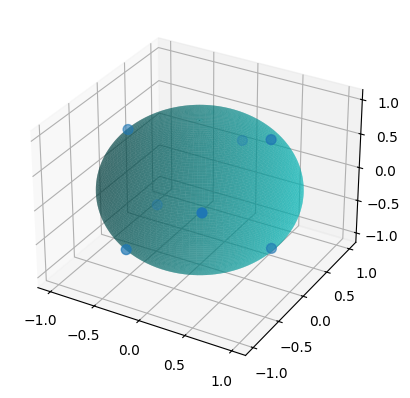

In [218]:
#####
# Parameters
#####
N = 7 # number of points
d = 3 # dimension of ambient space. Spheres $S^{d-1} \subset \mathbb{R}^d$.

tolProjGradNorm = 1e-5 # stops if norm of projected gradient is less or equal

maxIters = int( 5 * N / ( d * np.sqrt(tolProjGradNorm) ) ) # maximum number of iterations of GD.

Ntests = 500 # number of tests with different initial configuration

verboseGD = 0 # 1 to show final values of each test.

print('\nNumber of points: n = ' + str(N) )
print('\nDimension of ambient space: d = ' + str(d) )

print('\nMaximum iterations: ' + str(maxIters) )
print('\nTolerance on norm of projected gradient: ' + str(tolProjGradNorm) )

print('\nNumber of tests: ' + str(Ntests) )

#####
# Define the manifold as the product of N spheres.
#####
manilist = []
for _ in range(N): # for each point
    manilist.append(Sphere(d)) # add a new sphere

manifold = Product(manilist) # take the product manifold

#####
# Tests.
#####
Niters = [] # number of iterations of each test
Einitial = [] # list with initial energy of each test
Efinal = [] # list with final energy of each test

for k in range(Ntests): # each test
    print('\n----------------')
    print('\nTest number ' + str(k+1) + ' of ' + str(Ntests) + '...' )

    ########
    # Initial random configuration.
    ########
    winit =  manifold.random_point() # initial random configuration in the manifold.
    
    ########
    # Apply GD to minimize Elog.
    ########
    w, iters = grad_descent(manifold, winit, funElog, gradElog, maxIters, tolProjGradNorm)

    ######
    # Save final values
    ######
    Niters.append(iters)
    Einitial.append(funElog(winit))
    Efinal.append(funElog(w))
    
    ######
    # Show final values
    ######
    if verboseGD == 1 :
        print('\nNumber of iterations: ' + str(Niters[-1]) + ' of ' + str(maxIters) )
    
        print('\nLogarithmic Energy:')
        print(' -- in w initial : ',  Einitial[-1])
        print(' -- in w final   : ', Efinal[-1] )


######
# Plot points in S^2.
######
if d==3:
    plot_points( np.array(w) )



## Histogram of final values

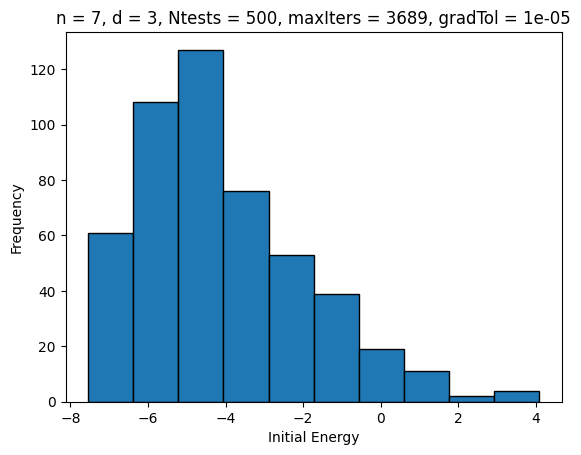

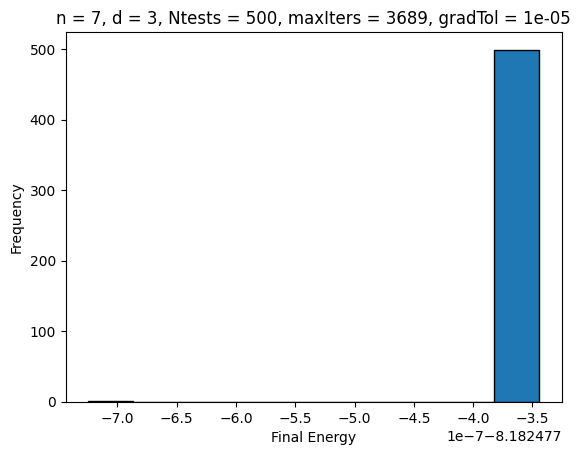

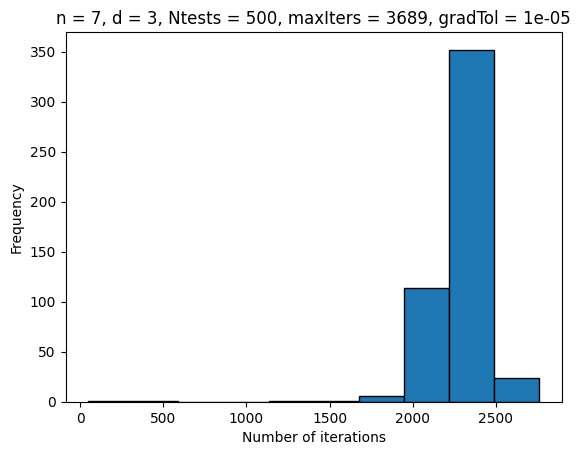

In [219]:
import matplotlib.pyplot as plt

plt.hist(Einitial, edgecolor='black')
plt.xlabel('Initial Energy')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', d = ' + str(d) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()

plt.hist(Efinal, edgecolor='black')
plt.xlabel('Final Energy')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', d = ' + str(d) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()

plt.hist(Niters, edgecolor='black')
plt.xlabel('Number of iterations')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', d = ' + str(d) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()


## Frecuencias de Energia Final

In [223]:
from collections import Counter

print('\nFrecuencias de cada energia final:')
Counter( np.round(Efinal, 7) )



Frecuencias de cada energia final:


Counter({np.float64(-8.1824773): 499, np.float64(-8.1824777): 1})

# Final Configuration

In [224]:
print('\nEnergy of final configuration:')

print(Efinal[-1])



Energy of final configuration:
-8.182477724531593


## Distance and Dot product between pairs of points

In [225]:
w = np.array(w)

print('\nDot product matrix:')
print( np.round( w @ w.T, 3) )

print('\nSquare Distance matrix:')
print( np.round( 2 * ( np.ones(n) - w @ w.T ), 3 ) )

print('\nDistance matrix:')
print( np.round( np.sqrt( 2 * ( np.ones(n) - w @ w.T ) ), 3 ) )



Dot product matrix:
[[ 1.     0.017  0.309 -0.808 -0.809 -0.017  0.309]
 [ 0.017  1.    -0.005  0.018 -0.007 -1.    -0.022]
 [ 0.309 -0.005  1.    -0.809  0.309  0.006 -0.809]
 [-0.808  0.018 -0.809  1.     0.309 -0.018  0.309]
 [-0.809 -0.007  0.309  0.309  1.     0.008 -0.808]
 [-0.017 -1.     0.006 -0.018  0.008  1.     0.021]
 [ 0.309 -0.022 -0.809  0.309 -0.808  0.021  1.   ]]

Square Distance matrix:
[[-0.     1.966  1.383  3.616  3.619  2.034  1.382]
 [ 1.966  0.     2.011  1.964  2.015  4.     2.044]
 [ 1.383  2.011 -0.     3.619  1.383  1.988  3.617]
 [ 3.616  1.964  3.619 -0.     1.383  2.037  1.382]
 [ 3.619  2.015  1.383  1.383 -0.     1.984  3.617]
 [ 2.034  4.     1.988  2.037  1.984  0.     1.957]
 [ 1.382  2.044  3.617  1.382  3.617  1.957  0.   ]]

Distance matrix:
[[  nan 1.402 1.176 1.902 1.902 1.426 1.176]
 [1.402 0.    1.418 1.401 1.419 2.    1.43 ]
 [1.176 1.418   nan 1.902 1.176 1.41  1.902]
 [1.902 1.401 1.902   nan 1.176 1.427 1.176]
 [1.902 1.419 1.176 1.176 

/tmp/ipykernel_15525/1392130141.py:10: RuntimeWarning: invalid value encountered in sqrt
  print( np.round( np.sqrt( 2 * ( np.ones(n) - w @ w.T ) ), 3 ) )


## Cartesian coordinates of final configuration

In [217]:
np.round(w,3)

array([[-0.573, -0.814,  0.098],
       [-0.254,  0.074, -0.964],
       [ 0.645, -0.549, -0.532],
       [-0.815,  0.576, -0.06 ],
       [ 0.572,  0.814, -0.099],
       [-0.259,  0.266,  0.929],
       [ 0.685, -0.368,  0.629]])